In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('Fraud.csv')


# ***Data Exploration and Preprocessing***


In [4]:
print("Dataset Overview:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69858 entries, 0 to 69857
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            69858 non-null  int64  
 1   type            69858 non-null  object 
 2   amount          69858 non-null  float64
 3   nameOrig        69858 non-null  object 
 4   oldbalanceOrg   69858 non-null  float64
 5   newbalanceOrig  69858 non-null  float64
 6   nameDest        69858 non-null  object 
 7   oldbalanceDest  69858 non-null  float64
 8   newbalanceDest  69857 non-null  float64
 9   isFraud         69857 non-null  float64
 10  isFlaggedFraud  69857 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 5.9+ MB
None

Descriptive Statistics:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  69858.000000  6.985800e+04   6.985800e+04    6.985800e+04   
mean       7.893326  1.640176e+05   9.043066e+05    9.202980

# ***Data Exploration and Preprocessing***


In [5]:
print("Dataset Overview:")
print(df.info())
print("\nDescriptive Statistics:")
print(df.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69858 entries, 0 to 69857
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            69858 non-null  int64  
 1   type            69858 non-null  object 
 2   amount          69858 non-null  float64
 3   nameOrig        69858 non-null  object 
 4   oldbalanceOrg   69858 non-null  float64
 5   newbalanceOrig  69858 non-null  float64
 6   nameDest        69858 non-null  object 
 7   oldbalanceDest  69858 non-null  float64
 8   newbalanceDest  69857 non-null  float64
 9   isFraud         69857 non-null  float64
 10  isFlaggedFraud  69857 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 5.9+ MB
None

Descriptive Statistics:
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  69858.000000  6.985800e+04   6.985800e+04    6.985800e+04   
mean       7.893326  1.640176e+05   9.043066e+05    9.202980

***Handle missing values and outliers in 'amount' using RobustScaler***


In [6]:
df['nameDest'] = df['nameDest'].fillna('Unknown')
df['oldbalanceDest'] = df['oldbalanceDest'].fillna(0)
df['newbalanceDest'] = df['newbalanceDest'].fillna(0)

In [7]:
robust_scaler = RobustScaler()
df['amount_scaled'] = robust_scaler.fit_transform(df['amount'].values.reshape(-1, 1))

# ***Feature Engineering***


In [8]:
df['balanceChangeOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balanceChangeDest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['type'] = df['type'].astype('category').cat.codes

In [9]:
df = df.drop(['nameOrig', 'nameDest', 'amount'], axis=1)

# ***Visualizing class imbalance***


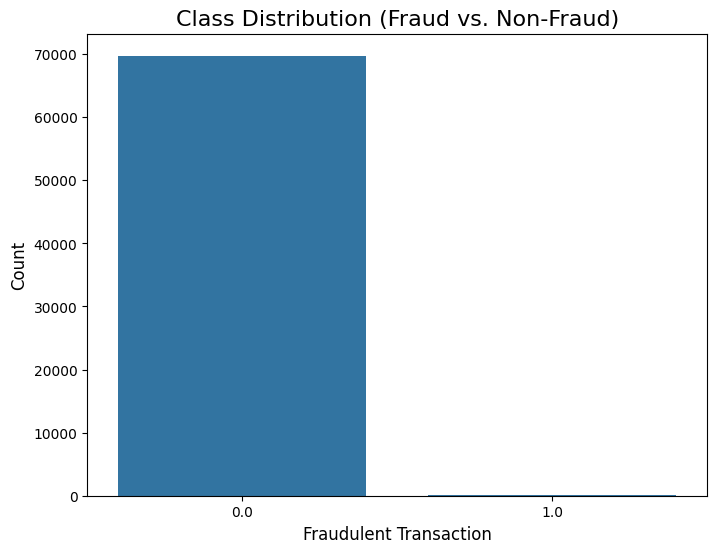

In [10]:
plt.figure(figsize=(8, 6))
sns.countplot(x='isFraud', data=df)
plt.title('Class Distribution (Fraud vs. Non-Fraud)', fontsize=16)
plt.xlabel('Fraudulent Transaction', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

# ***Correlation Matrix***


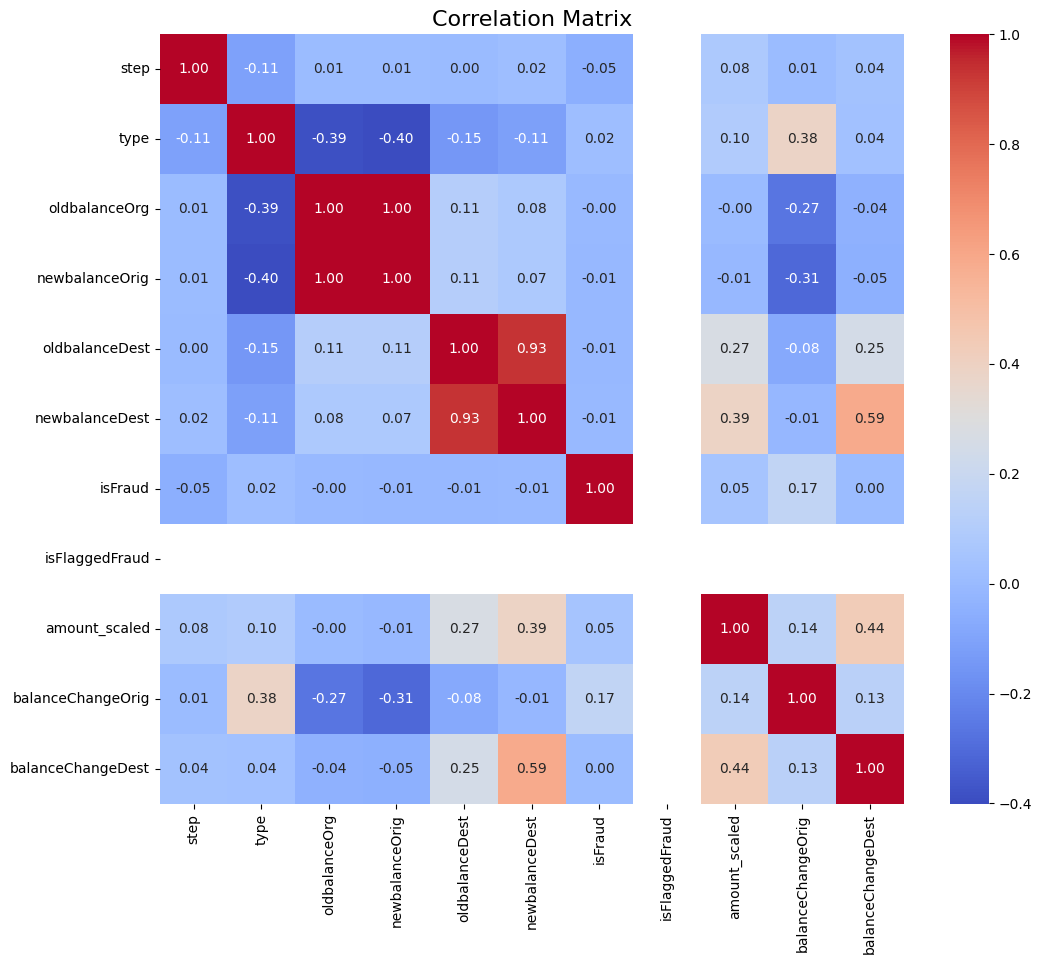

In [11]:
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix', fontsize=16)
plt.show()

***Sampling a fraction of the dataset for faster iterations and preparing data for modeling and train-test split***


In [12]:
df_sampled = df.sample(frac=0.1, random_state=42)

X = df_sampled.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df_sampled['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ***Feature Scaling***


In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

***Using SMOTE for imbalanced classification***

In [14]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


# ***Model Training and Evaluation***


In [17]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "SVM": SVC(probability=True, random_state=42),
    "Voting Classifier": VotingClassifier(estimators=[
        ('rf', RandomForestClassifier(n_estimators=50, max_depth=8, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=50, max_depth=5, random_state=42)),
        ('lr', LogisticRegression(random_state=42, max_iter=1000))
    ], voting='soft')
}

results = {}
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    results[name] = {
        "Accuracy": model.score(X_test_scaled, y_test),
        "ROC-AUC": roc_auc_score(y_test, y_prob),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "ROC Curve": (roc_curve(y_test, y_prob)),
        "Precision-Recall Curve": (precision_recall_curve(y_test, y_prob))
    }


In [18]:
for name, result in results.items():
    print(f"\n{name} Results:")
    print(f"  Accuracy: {result['Accuracy']:.4f}")
    print(f"  ROC-AUC: {result['ROC-AUC']:.4f}")
    print(f"  Precision: {result['Precision']:.4f}")
    print(f"  Recall: {result['Recall']:.4f}")
    print(f"  F1-Score: {result['F1-Score']:.4f}")
    print("  Classification Report:")
    print(result['Classification Report'])
    print("  Confusion Matrix:")
    print(result['Confusion Matrix'])



Logistic Regression Results:
  Accuracy: 0.9036
  ROC-AUC: 0.9240
  Precision: 0.0099
  Recall: 0.5000
  F1-Score: 0.0194
  Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95      2092
         1.0       0.01      0.50      0.02         4

    accuracy                           0.90      2096
   macro avg       0.50      0.70      0.48      2096
weighted avg       1.00      0.90      0.95      2096

  Confusion Matrix:
[[1892  200]
 [   2    2]]

Random Forest Results:
  Accuracy: 0.9986
  ROC-AUC: 0.9947
  Precision: 1.0000
  Recall: 0.2500
  F1-Score: 0.4000
  Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2092
         1.0       1.00      0.25      0.40         4

    accuracy                           1.00      2096
   macro avg       1.00      0.62      0.70      2096
weighted avg       1.00      1.00      1.00      2096

  Confusi

***Visualizing Confusion Matrix***


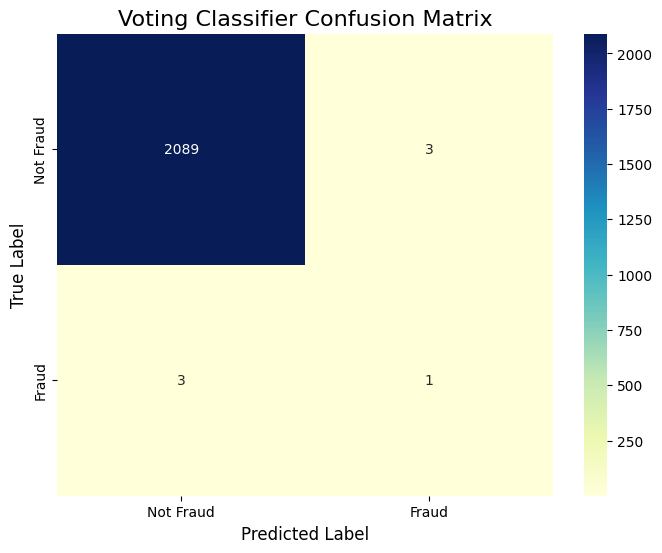

In [20]:
plt.figure(figsize=(8, 6))
sns.heatmap(result['Confusion Matrix'], annot=True, fmt="d", cmap="YlGnBu", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title(f"{name} Confusion Matrix", fontsize=16)
plt.show()


***Visualizing ROC Curve***


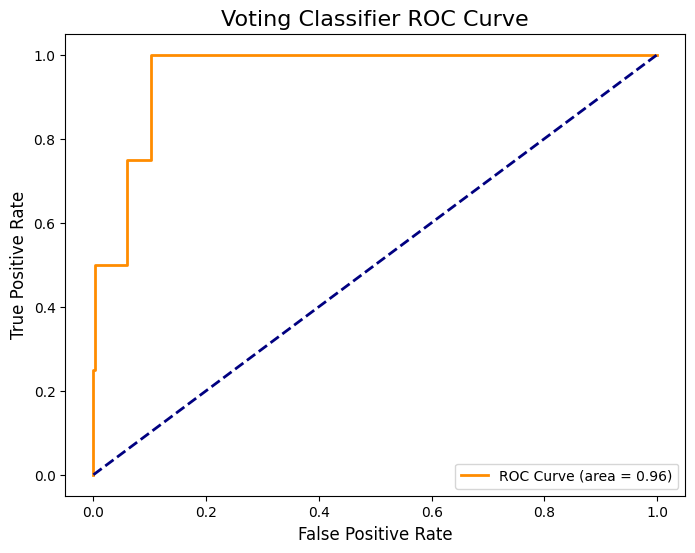

In [21]:
fpr, tpr, _ = result['ROC Curve']
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'{name} ROC Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=10)
plt.show()



***Visualizing Precision-Recall Curve by Using y_prob (predicted probabilities) instead of result***['ROC Curve'][2]




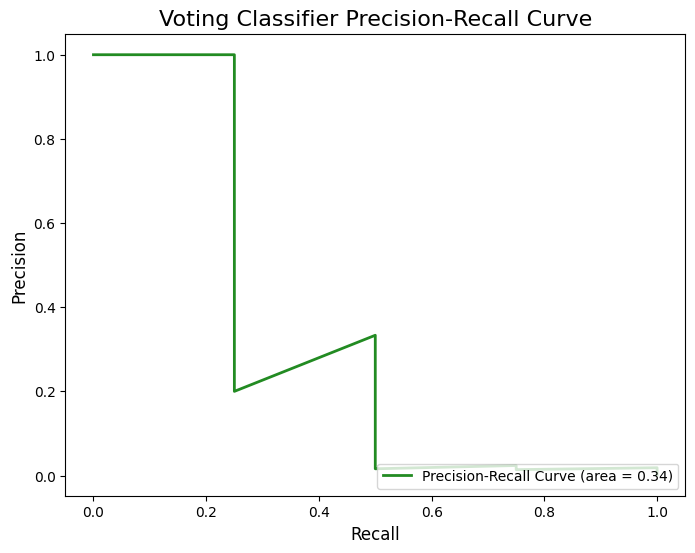

In [26]:
precision, recall, _ = result['Precision-Recall Curve']

average_precision = average_precision_score(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='forestgreen', lw=2, label=f'Precision-Recall Curve (area = {average_precision:.2f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title(f'{name} Precision-Recall Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=10)
plt.show()



# ***FRAUD RATE*** and ***Saving the fraud rate to a CSV file***




In [25]:
fraud_rate = df['isFraud'].sum() / len(df)
print(f"\nFraud Rate: {fraud_rate:.4f}")

fraud_rate_df = pd.DataFrame({'Fraud Rate': [fraud_rate]})

fraud_rate_df.to_csv('fraud_rate.csv', index=False)
print("Fraud rate saved to fraud_rate.csv")


Fraud Rate: 0.0015
Fraud rate saved to fraud_rate.csv
